# Get t events strat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

In [3]:
# df = df[-1_000_000:]

In [4]:
df.index.is_monotonic_increasing

True

In [5]:
df.head()

,open,high,low,close,volume
time,,,,,
2017-08-17 04:21:13.356,4261.48,4280.56,4261.48,4266.29,5.002297
2017-08-17 04:29:19.766,4266.29,4270.41,4261.32,4267.47,5.356629
2017-08-17 04:33:00.057,4261.45,4280.56,4261.45,4267.99,7.935627
2017-08-17 04:39:32.027,4296.63,4300.38,4296.63,4300.38,5.027790
2017-08-17 04:43:05.191,4300.38,4300.38,4300.38,4300.38,5.109679


In [6]:
def get_daily_vol(close, span0=10000):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=2))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

def get_t_events(g_raw, h):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold (possibly float or int)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    t_events, s_pos, s_neg = [], 0, 0
    diff = np.log(g_raw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            print(s_pos+diff.loc[i], type(s_pos+diff.loc[i]))
            print(s_neg+diff.loc[i], type(s_neg+diff.loc[i]))
            break
        s_pos, s_neg=max(0., pos), min(0., neg)
        if s_neg<-h:
            s_neg=0;t_events.append(i)
        elif s_pos>h:
            s_pos=0;t_events.append(i)
    return pd.DatetimeIndex(t_events)

def get_t_events_variable(g_raw, h, m):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold pandas series vol
    m -- minimum threshold (float, ex: 0.02)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    h = h.map(lambda x: x if x>=m else m)
    t_events, s_pos, s_neg = [], 0, 0
    diff = np.log(g_raw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            print(s_pos+diff.loc[i], type(s_pos+diff.loc[i]))
            print(s_neg+diff.loc[i], type(s_neg+diff.loc[i]))
            break
        s_pos, s_neg=max(0., pos), min(0., neg)
        th = h[h.index.get_loc(i, method="pad")]
        if s_neg<-th:
            s_neg=0;t_events.append(i)
        elif s_pos>th:
            s_pos=0;t_events.append(i)
    return pd.DatetimeIndex(t_events)

In [7]:
vol = get_daily_vol(df.close)

In [8]:
vol

time
2017-08-19 04:25:59.354         NaN
2017-08-19 04:57:14.915    0.016215
2017-08-19 05:16:47.885    0.011695
2017-08-19 05:31:30.438    0.013451
2017-08-19 06:05:00.076    0.011669
                             ...   
2021-06-19 16:27:04.502    0.012078
2021-06-19 16:27:20.667    0.012077
2021-06-19 16:27:26.627    0.012076
2021-06-19 16:27:44.405    0.012075
2021-06-19 16:27:48.270    0.012074
Name: close, Length: 11798483, dtype: float64

In [9]:
print(f"max: {max(vol[1:])}")
print(f"mean: {np.mean(vol)}")
print(f"median: {np.median(vol[1:])}")

max: 0.15677271710535778
mean: 0.02651504315228314
median: 0.022812545829035108


In [10]:
df["vol"] = vol

In [ ]:
t_events = get_t_events_variable(df.close,h=df.vol, m=0.02)

In [ ]:
t_events

In [ ]:
side = df.close.reindex(t_events).diff().shift(-1).map(lambda x: 1 if x>0 else 0)
side

In [ ]:
side.to_csv("../data/side.csv")

## Plotting

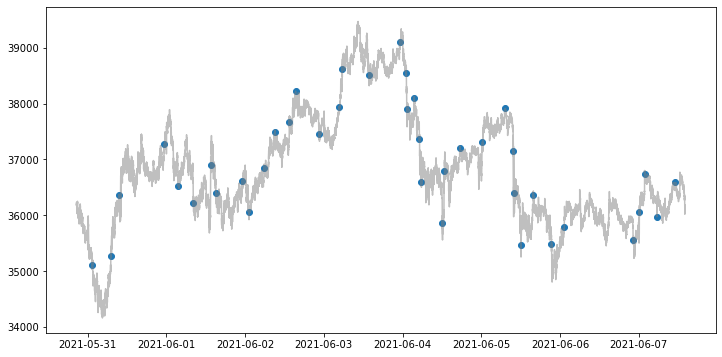

In [159]:
a = 700000
b = 800000
test = df[a:b].reindex(t_events)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.close[a:b], color="gray", alpha=.5)
ax.scatter(test.index, test.close)